# Notebook 04 – Model Interpretability and Feature Analysis

This notebook examines the behavior of the baseline text classification model trained in Notebook 03. The primary objective is to understand which lexical features drive the model’s predictions for each incident type and to assess whether these patterns align with domain intuition.

We first reload the trained Logistic Regression model and TF–IDF vectorizer, and verify performance on the held-out test set. We then analyze the learned coefficients to identify the most influential unigrams and bigrams for each `event_type`. Finally, we outline a simple error analysis workflow for inspecting misclassified examples, which can be extended in future work once the dataset or model is made more challenging.

This interpretability step is intended to complement aggregate metrics (e.g., accuracy, F1-score) with a more fine-grained view of how the model encodes and separates different categories of cyber incidents.

## Reload Artifacts and Verify Baseline Performance

We begin by loading the serialized TF–IDF vectorizer, the baseline Logistic Regression model, and the TF–IDF representations of the test set generated in Notebook 02. As a sanity check, we recompute the evaluation metrics on the held-out test set to confirm that we are operating on the same configuration as in Notebook 03.

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath("../src"))
from triage.preprocess import clean_description
from triage.model import predict_event_type
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load vectorizer and model, and test data
vectorizer = joblib.load("../models/vectorizer.joblib")
clf = joblib.load("../models/baseline_logreg.joblib")
X_test = joblib.load("../models/X_test_tfidf.joblib")
y_test = joblib.load("../models/y_test.joblib")
print("\n---Baseline Logistic Regression model and vectorizer loaded.---")
print("\n---Test data loaded.---")
print(f"\nX_test shape: {X_test.shape}")
print(f"Number of test labels: {len(y_test)}")
print(f"\nUnique labels in test set: {set(y_test)}")
print(f"Class distribution in test set: {pd.Series(y_test).value_counts().to_dict()}")

# Recompute metrics on test set
y_pred = clf.predict(X_test)
print("\n---Classification Report---")
print(classification_report(y_test, y_pred)) # Print classification report
print("\n---Confusion Matrix---")
print(confusion_matrix(y_test, y_pred)) # Print confusion matrix


---Baseline Logistic Regression model and vectorizer loaded.---

---Test data loaded.---

X_test shape: (150000, 5000)
Number of test labels: 150000

Unique labels in test set: {'credential_compromise', 'policy_violation', 'benign_activity', 'web_attack', 'insider_threat', 'malware', 'data_exfiltration', 'suspicious_network_activity', 'access_abuse', 'phishing'}
Class distribution in test set: {'policy_violation': 16817, 'insider_threat': 15579, 'access_abuse': 15517, 'data_exfiltration': 15070, 'benign_activity': 15069, 'web_attack': 15031, 'suspicious_network_activity': 14970, 'credential_compromise': 14337, 'phishing': 13860, 'malware': 13750}

---Classification Report---
                             precision    recall  f1-score   support

               access_abuse       0.92      0.88      0.90     15517
            benign_activity       0.92      0.92      0.92     15069
      credential_compromise       0.92      0.96      0.94     14337
          data_exfiltration       0.92

## Feature Importance by Class

To understand which textual patterns the classifier relies on, we examine the learned coefficients associated with each TF-IDF feature. For a linear model such as Logistic Regression, the magnitude and sign of these coefficients indicate how strongly a given token or n-gram contributes to predicting a particular class, holding other features constant.

**Analysis approach:**
- Extract coefficient weights for each event type from the OneVsRest classifier
- Identify **positive features**: Terms that strongly indicate a particular class
- Identify **negative features**: Terms that push away from a particular class
- Visualize the top features per class to understand discriminative patterns

**Visualizations:**
1. **Per-class feature tables**: Show the top 15 positive and negative terms for each event type
2. **Global heatmap**: Display the top 30 most important features across all classes
3. **Feature importance distribution**: Shows which features are most discriminative overall

**Expected patterns:**
- **Phishing**: Email-related terms (vpn, login, password, verify, link)
- **Malware**: Execution terms (powershell, process, executable, encrypt, ransom)
- **Web attack**: HTTP terms (sql, injection, brute force, endpoint, payload)
- **Access abuse**: Authentication terms (failed login, impossible travel, privilege)
- **Data exfiltration**: Transfer terms (download, upload, sharepoint, cloud storage)
- **Policy violation**: Compliance terms (unauthorized, usb drive, dlp, policy)
- **Benign activity**: Operational terms (maintenance, backup, patch, planned)

In [2]:
feature_names = vectorizer.get_feature_names_out()
class_labels = clf.classes_

def get_coef_vector_for_class(class_label: str) -> np.ndarray:
    """Return the coefficient vector for a given class from the OneVsRest wrapper."""
    class_index = list(class_labels).index(class_label)
    lr_model = clf.estimators_[class_index]  # underlying LogisticRegression
    # For binary relevance, coef_ is shape (1, n_features)
    return lr_model.coef_[0]

def top_bottom_terms_for_class(class_label: str, top_n: int = 15) -> pd.DataFrame:
    """
    Build a DataFrame with the top positive (most indicative of this class)
    and top negative (features that push away from this class) terms.
    """
    coefs = get_coef_vector_for_class(class_label)
    idx_sorted = np.argsort(coefs)

    # Negative = smallest weights (most negative)
    bottom_idx = idx_sorted[:top_n]
    # Positive = largest weights
    top_idx = idx_sorted[-top_n:][::-1]

    df = pd.DataFrame({
        "positive_term": feature_names[top_idx],
        "positive_weight": coefs[top_idx],
        "negative_term": feature_names[bottom_idx],
        "negative_weight": coefs[bottom_idx],
    })

    return df

# Display for each class
for label in class_labels:
    print(f"\n=== Feature impact for class: {label} ===")
    display(top_bottom_terms_for_class(label, top_n=15))



=== Feature impact for class: access_abuse ===


,positive_term,positive_weight,negative_term,negative_weight
0,attempts,5.362385,filepath,-4.164737
1,repeated,5.277278,file,-4.041810
2,aligns,5.210555,edr,-3.991754
3,ips,4.998294,dlp,-3.851139
4,login,4.832284,hr,-3.626422
5,inclduing,3.908741,security,-3.609569
6,ailgns,3.827569,indciators consistent,-3.571832
7,email gateawy,3.611616,network,-3.403385
8,successful,3.590002,fired,-3.373059
9,explicitly denies,3.547225,software,-3.364082



=== Feature impact for class: benign_activity ===


,positive_term,positive_weight,negative_term,negative_weight
0,security,6.225301,access,-5.553207
1,cdn,3.992172,filepath,-4.435643
2,normal,3.851039,dlp,-4.262548
3,sceurity,3.777054,domain thsi,-3.783523
4,securiyt,3.600679,policy,-3.735760
5,change,3.317650,knwon,-3.505227
6,update,3.280231,mitre,-3.452610
7,seucrity,3.238622,follwoing,-3.208414
8,legitimtae,3.209409,multiple,-3.169052
9,secuirty,3.062782,files,-3.048405



=== Feature impact for class: credential_compromise ===


,positive_term,positive_weight,negative_term,negative_weight
0,mfa,6.571069,host,-3.199175
1,session,5.234366,filepath,-3.136072
2,access,4.512213,failed lgoin,-3.110555
3,tokens,4.218182,email,-3.063470
4,corresponds,3.826221,analyssi indicates,-3.019698
5,briefly thne,3.708275,dlp,-2.874935
6,authentication,3.693820,edr,-2.848850
7,authentciation,3.466859,file,-2.686848
8,dip,3.443837,historiacl,-2.683207
9,idp,3.389204,icnonsistent,-2.629355



=== Feature impact for class: data_exfiltration ===


,positive_term,positive_weight,negative_term,negative_weight
0,filepath dlp,5.992265,consistent,-3.464396
1,dlp,4.969948,tema,-3.282858
2,filepath,4.750726,login,-3.205293
3,authorization multiple,4.397495,outsied,-3.188406
4,outbound,4.161564,olivia,-3.069760
5,proxy,4.134903,bheavior,-3.023958
6,party,3.584336,behvaior,-2.859419
7,bulk,3.528546,exfiltration ovre,-2.826456
8,weeks ago,3.343022,atetmpts,-2.779743
9,flie access,3.291455,form srv,-2.756469



=== Feature impact for class: insider_threat ===


,positive_term,positive_weight,negative_term,negative_weight
0,hr,8.872039,consistent,-4.272868
1,access,4.507848,lacks,-3.940958
2,temporal,3.923961,login,-3.896409
3,does,3.843911,tarffic,-3.761499
4,job,3.803340,triaeg shows,-3.748019
5,documents,3.478708,behavior,-3.485463
6,ipaddr cn,3.446088,leigtimate,-3.467384
7,dlp,3.386684,match historical,-3.287601
8,iniital findings,3.326941,infrastructure,-3.059517
9,fil,3.303542,originated frmo,-2.994543



=== Feature impact for class: malware ===


,positive_term,positive_weight,negative_term,negative_weight
0,edr,10.296389,access,-2.792505
1,malware,5.030804,email,-2.403399
2,host,4.629299,traffic,-2.266724
3,der,3.697939,dlp,-2.156140
4,powershell,3.682137,login,-2.150285
5,analysis,3.615508,network,-2.144341
6,ransomware,3.569245,policy,-2.118542
7,av,3.177367,normal,-1.991563
8,erd,3.123472,user,-1.951819
9,malwaer,3.086715,application,-1.913238



=== Feature impact for class: phishing ===


,positive_term,positive_weight,negative_term,negative_weight
0,email,7.524984,activity,-2.298314
1,ip,4.696943,ipaddr,-2.243640
2,campaign,4.645398,access,-2.076261
3,sender,4.176121,edr,-1.688695
4,emali,4.149363,malware,-1.659970
5,url,3.921484,normal,-1.614599
6,page,3.876660,data,-1.610891
7,eamil,3.853313,patterns,-1.555709
8,emial,3.787115,pattern,-1.546481
9,mail,3.603317,traffic,-1.536600



=== Feature impact for class: policy_violation ===


,positive_term,positive_weight,negative_term,negative_weight
0,policy,6.496463,login,-5.029015
1,poliyc,4.808186,ticket,-3.390035
2,polciy,4.591039,ips,-3.336104
3,filepath,3.640351,frmo macbook,-3.297633
4,ploicy,3.629354,ipaddr edr,-3.148637
5,poilcy,3.611523,historical bsaelines,-3.128015
6,volume,3.608984,internal,-3.111691
7,overlaps,3.544273,auth,-2.886374
8,sevrice,3.331802,legtiimate,-2.861508
9,deviation,3.315734,attempts,-2.852309



=== Feature impact for class: suspicious_network_activity ===


,positive_term,positive_weight,negative_term,negative_weight
0,ids,5.169412,access,-4.940436
1,network,4.243087,dlp,-3.668545
2,matches,3.824931,aligns,-3.536266
3,internal,3.807318,policy,-3.330974
4,hosts,3.787095,eamil,-3.301463
5,automation malicious,3.535458,account,-3.270102
6,smb,3.182613,authentictaion,-3.180363
7,dns,3.111742,user,-3.076411
8,infrastructure,3.072875,known,-3.037067
9,logs volumetric,2.987328,operational issue,-2.917817



=== Feature impact for class: web_attack ===


,positive_term,positive_weight,negative_term,negative_weight
0,ips,7.481358,shows reconnaissance,-3.542151
1,set ips,4.825554,email,-3.408239
2,dos,4.704141,ssytem,-3.332759
3,traffic,4.496574,software,-3.262324
4,sql,4.159036,dlp,-3.251354
5,waf,3.970401,access,-3.202185
6,sugegst,3.612363,activity non,-3.174136
7,logni ipaddr,3.611168,inconsistetn,-3.021976
8,trfafic patterns,3.508788,security,-2.969822
9,ldap kerberos,3.458745,movemetn,-2.870247


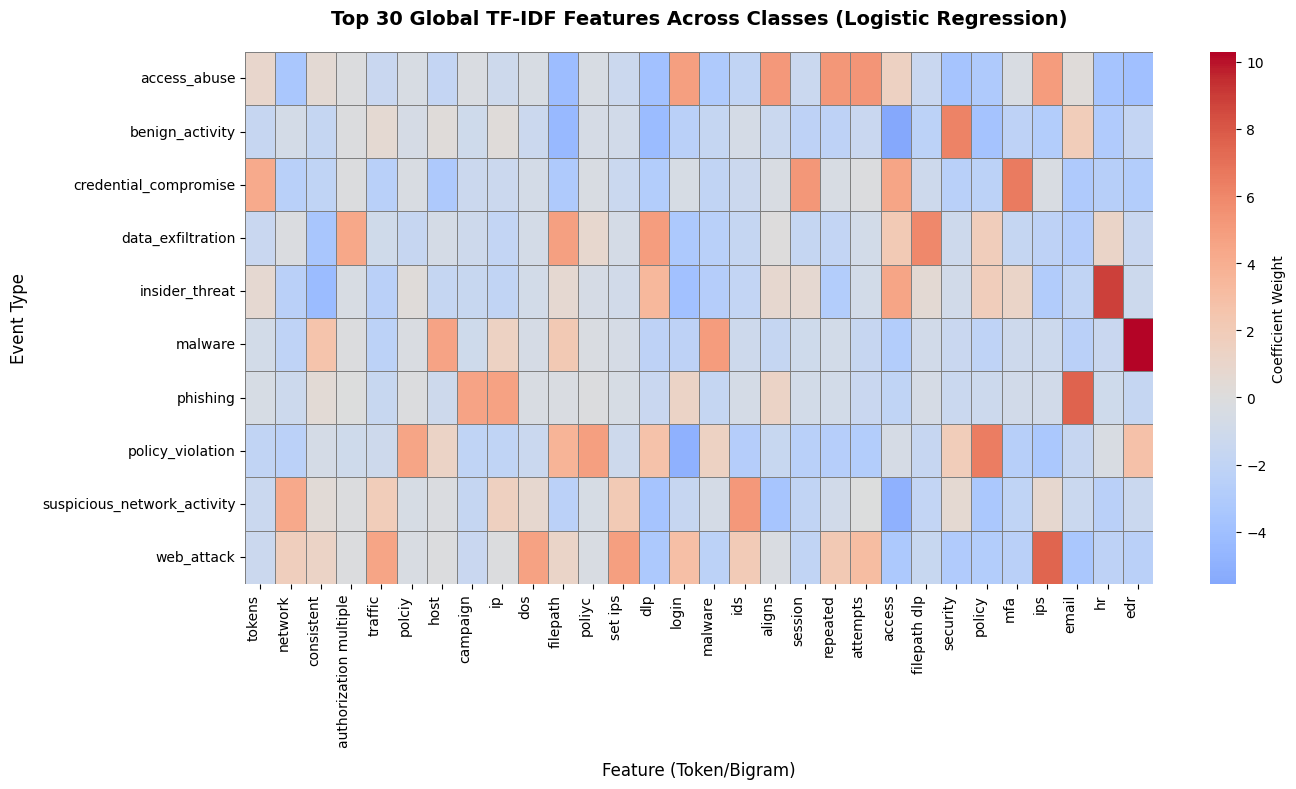


--- Feature Weight Distribution Analysis ---


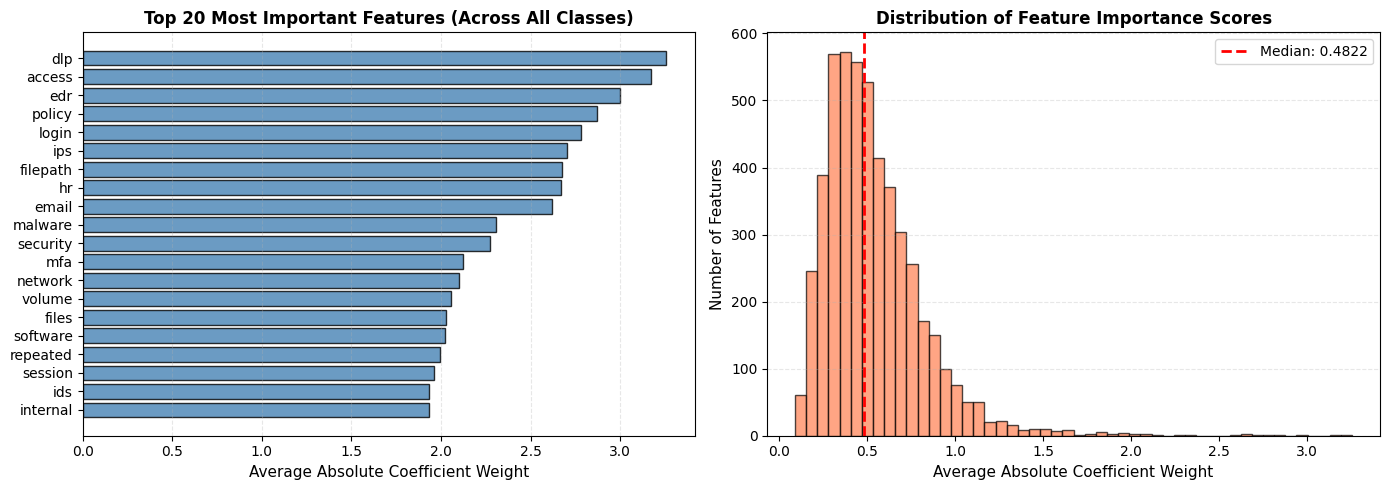

In [3]:
import seaborn as sns

# Build a full coefficient matrix: shape (n_classes, n_features)
coef_matrix = []
for label in class_labels:
    coef_matrix.append(get_coef_vector_for_class(label))
coef_matrix = np.vstack(coef_matrix)  # (n_classes, n_features)

# Choose the top K globally important features by absolute weight
K = 30
abs_coefs = np.abs(coef_matrix).max(axis=0)  # max abs weight per feature across classes
top_global_idx = np.argsort(abs_coefs)[-K:]
top_global_features = feature_names[top_global_idx]

heatmap_data = coef_matrix[:, top_global_idx]

# Enhanced heatmap visualization
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, 
            cmap="coolwarm", 
            center=0,
            yticklabels=class_labels,
            xticklabels=top_global_features,
            cbar_kws={'label': 'Coefficient Weight'},
            linewidths=0.5,
            linecolor='gray',
            annot=False)

plt.title("Top 30 Global TF-IDF Features Across Classes (Logistic Regression)", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Feature (Token/Bigram)", fontsize=12, labelpad=10)
plt.ylabel("Event Type", fontsize=12, labelpad=10)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Additional visualization: Feature importance distribution
print("\n--- Feature Weight Distribution Analysis ---")
feature_importance = np.abs(coef_matrix).mean(axis=0)
sorted_importance = np.sort(feature_importance)[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Top 20 features by average absolute weight
top_20_idx = np.argsort(feature_importance)[-20:][::-1]
top_20_features = feature_names[top_20_idx]
top_20_weights = feature_importance[top_20_idx]

ax1.barh(range(20), top_20_weights, color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_yticks(range(20))
ax1.set_yticklabels(top_20_features)
ax1.set_xlabel('Average Absolute Coefficient Weight', fontsize=11)
ax1.set_title('Top 20 Most Important Features (Across All Classes)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()

# Plot 2: Distribution of feature importance
ax2.hist(feature_importance, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Average Absolute Coefficient Weight', fontsize=11)
ax2.set_ylabel('Number of Features', fontsize=11)
ax2.set_title('Distribution of Feature Importance Scores', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axvline(np.median(feature_importance), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(feature_importance):.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

## Error Analysis Template

Although the current model achieves perfect accuracy on this synthetic test set, it is useful to establish an error analysis workflow that can be reused if the dataset or modeling setup is made more challenging.

The general idea is to join the predicted labels back to the underlying text and isolate those instances where the model’s prediction differs from the ground truth. Analysts can then manually inspect these cases to understand common failure modes and refine the data generation process, feature engineering, or model architecture accordingly.


--- Misclassification Analysis ---
Total test samples: 150000
Correctly classified: 137939
Misclassified: 12061
Error rate: 8.04%

--- Confusion Patterns in Misclassified Samples ---
               true_label             pred_label  count
14       policy_violation                malware   1240
6       data_exfiltration         insider_threat    654
8          insider_threat  credential_compromise    641
10         insider_threat       policy_violation    632
1            access_abuse               phishing    623
5   credential_compromise           access_abuse    622
3         benign_activity               phishing    617
17             web_attack           access_abuse    615
0            access_abuse  credential_compromise    613
11       policy_violation        benign_activity    603


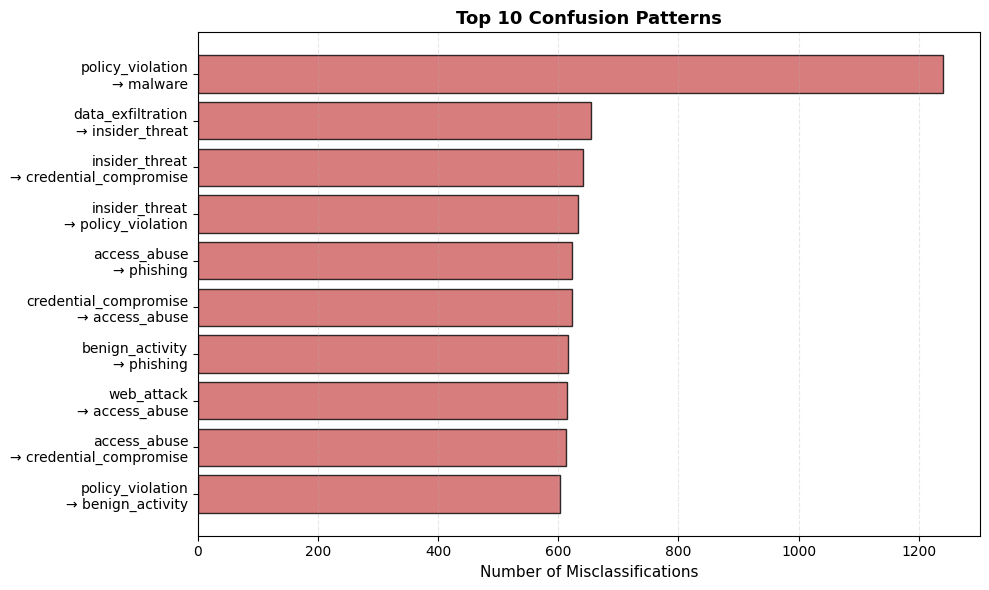


--- Sample Misclassified Examples ---


,text,true_label,pred_label
9,early investigtaion reveals repaeted fialed lo...,credential_compromise,access_abuse
18,from the first pass reveiw that srv app is run...,data_exfiltration,policy_violation
33,early investigation reveasl thta srv file is r...,data_exfiltration,policy_violation
34,early investigation reveals large outbound tra...,insider_threat,data_exfiltration
46,early investigation reveals that atuhenticatio...,policy_violation,benign_activity
62,based on current evidence volumetric http traf...,suspicious_network_activity,web_attack
73,fisrt level review shows repeated account lokc...,credential_compromise,access_abuse
87,initial trigae shows cnocerning behavior form ...,data_exfiltration,insider_threat
91,early investigation revaels repeated http requ...,suspicious_network_activity,web_attack
93,from the first pass review that srv cd is runn...,insider_threat,policy_violation


In [4]:
df = pd.read_csv("../data/cyber_incidents_simulated.csv")

df["cleaned_description"] = df["description"].apply(clean_description)

# Use the same split parameters used during training
X_text = df["cleaned_description"]
y = df["event_type"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

# Regenerate predictions on THIS test split
X_test_vec = vectorizer.transform(X_test_text)
y_pred = clf.predict(X_test_vec)

error_df = pd.DataFrame({
    "text": X_test_text.reset_index(drop=True),
    "true_label": y_test.reset_index(drop=True),
    "pred_label": pd.Series(y_pred).reset_index(drop=True),
})

misclassified = error_df[error_df["true_label"] != error_df["pred_label"]]

print(f"\n--- Misclassification Analysis ---")
print(f"Total test samples: {len(error_df)}")
print(f"Correctly classified: {len(error_df) - len(misclassified)}")
print(f"Misclassified: {len(misclassified)}")
print(f"Error rate: {len(misclassified)/len(error_df)*100:.2f}%")

if len(misclassified) > 0:
    print(f"\n--- Confusion Patterns in Misclassified Samples ---")
    confusion_pairs = misclassified.groupby(['true_label', 'pred_label']).size().reset_index(name='count')
    confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
    print(confusion_pairs.head(10))
    
    # Visualize confusion patterns
    if len(confusion_pairs) > 0:
        plt.figure(figsize=(10, 6))
        top_confusions = confusion_pairs.head(10)
        labels = [f"{row['true_label']}\n→ {row['pred_label']}" for _, row in top_confusions.iterrows()]
        plt.barh(range(len(top_confusions)), top_confusions['count'], color='indianred', alpha=0.8, edgecolor='black')
        plt.yticks(range(len(top_confusions)), labels)
        plt.xlabel('Number of Misclassifications', fontsize=11)
        plt.title('Top 10 Confusion Patterns', fontsize=13, fontweight='bold')
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("\n--- Sample Misclassified Examples ---")
    display(misclassified.head(10))
else:
    print("\nNo misclassifications found - model achieves perfect accuracy on test set!")
    print("This is expected for the synthetic dataset with distinct class patterns.")

## Discussion and Future Work

The results of this interpretability analysis indicate that the baseline model relies on highly discriminative lexical cues to distinguish between incident categories. This behavior is consistent with the controlled nature of the synthetic dataset, where event descriptions were generated using deterministic templates with limited lexical overlap. Consequently, the model achieves perfect performance, and the extracted top-weighted features provide a clear mapping between event type and linguistic expression.

Despite the utility of this baseline, several limitations warrant further investigation. The linguistic homogeneity of the dataset does not reflect the variability present in operational security environments, where incident narratives may be noisy, abbreviated, or influenced by individual analyst writing styles. Increasing narrative diversity and introducing realistic noise—such as ambiguous phrasing, partial descriptions, irrelevant context, or multi-event scenarios—would create a more challenging testbed and allow for a more meaningful evaluation of model robustness.

Beyond dataset refinement, future work could explore alternative modeling paradigms. Transformer-based encoders (e.g., BERT or domain-adapted variants) may capture richer semantic relationships, while hybrid models combining narrative text with structured features could provide a more holistic view of each incident. Additionally, formalizing the misclassification analysis pipeline and incorporating active learning may support iterative improvement of both the dataset and the model.